In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

### Set Random seed

This is to ensure results are repoducibile and consistent across runs

In [2]:
# To ensure reproducibility and consistent results across runs
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
# Trnsformation for the dataset to convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

In [5]:
print(f"Training set: {len(train_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

Training set: 60000 images
Test set: 10000 images


In [6]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [7]:
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training subset: {len(train_subset)} images")
print(f"Validation subset: {len(val_subset)} images")
print(f"Test set: {len(test_dataset)} images")

Training subset: 54000 images
Validation subset: 6000 images
Test set: 10000 images


### Dataset preview

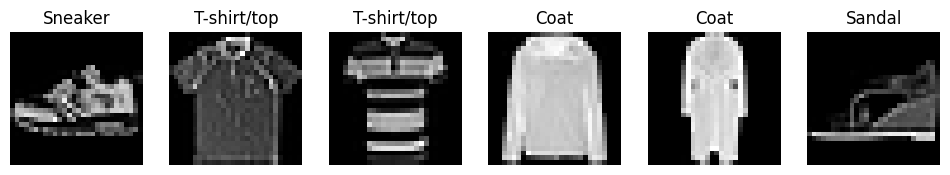

In [8]:
classes = train_subset.dataset.classes

def show_samples():
    images, labels = next(iter(train_loader))
    fig, axes = plt.subplots(1, 6, figsize=(12, 3))
    for i in range(6):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()

show_samples()

### Multi-Layer Perceptron (MLP) Model  

This cell defines a simple fully connected neural network for classifying 28×28 grayscale images.  
The model consists of:
- A flattening layer to convert the 2D image into a 784-dimensional vector  
- Two hidden fully connected layers with ReLU activation (256 → 128 units)  
- An output layer producing logits for 10 classes  

This architecture serves as a lightweight baseline for image classification tasks.

In [9]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.flatten(x)  # Flatten 28x28 → 784
        # two hidden layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Using device: cuda


In [11]:
patience = 3              # number of epochs to wait for improvement
best_val_loss = np.inf
epochs_no_improve = 0
max_epochs = 1000         # just a safety limit
best_model_state = None

for epoch in range(1, max_epochs + 1):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # -------- Validation Step --------
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:   # Make sure you have a val_loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # -------- Early Stopping Logic --------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("\nEarly stopping triggered!")
        print(f"Best Validation Loss: {best_val_loss:.4f}")
        break

# Load the best model state
model.load_state_dict(best_model_state)
print("Restored best model parameters.")

Epoch 1 | Train Loss: 0.5375 | Val Loss: 0.4079
Epoch 2 | Train Loss: 0.3766 | Val Loss: 0.3884
Epoch 3 | Train Loss: 0.3385 | Val Loss: 0.3668
Epoch 4 | Train Loss: 0.3114 | Val Loss: 0.3341
Epoch 5 | Train Loss: 0.2898 | Val Loss: 0.3240
Epoch 6 | Train Loss: 0.2750 | Val Loss: 0.3120
Epoch 7 | Train Loss: 0.2638 | Val Loss: 0.3151
  No improvement for 1 epoch(s).
Epoch 8 | Train Loss: 0.2493 | Val Loss: 0.3068
Epoch 9 | Train Loss: 0.2377 | Val Loss: 0.3148
  No improvement for 1 epoch(s).
Epoch 10 | Train Loss: 0.2308 | Val Loss: 0.3038
Epoch 11 | Train Loss: 0.2208 | Val Loss: 0.3026
Epoch 12 | Train Loss: 0.2092 | Val Loss: 0.3142
  No improvement for 1 epoch(s).
Epoch 13 | Train Loss: 0.2013 | Val Loss: 0.3301
  No improvement for 2 epoch(s).
Epoch 14 | Train Loss: 0.1962 | Val Loss: 0.3216
  No improvement for 3 epoch(s).

Early stopping triggered!
Best Validation Loss: 0.3026
Restored best model parameters.


In [12]:
model.eval()
correct, total = 0, 0
all_preds = []
all_labels = []

misclassified_images = []
misclassified_preds = []
misclassified_labels = []


In [13]:

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        images = images.to("cpu")
        labels = labels.to("cpu")

        _, predicted = torch.max(outputs, 1)
        predicted = predicted.to("cpu")

        mask = predicted != labels

        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

        total += labels.size(0)
        masks = predicted != labels

        correct += (~masks).sum().item()

        for img, pred, label, is_wrong in zip(images, predicted, labels, mask):
            if is_wrong:
                misclassified_images.append(img)
                misclassified_preds.append(pred.item())
                misclassified_labels.append(label.item())

accuracy = 100 * correct / total
f1_score = f1_score(all_labels, all_preds, average='weighted')


print(f"F1 Score (Macro): {f1_score:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

F1 Score (Macro): 0.8850
Test Accuracy: 88.51%


<Figure size 1700x1200 with 0 Axes>

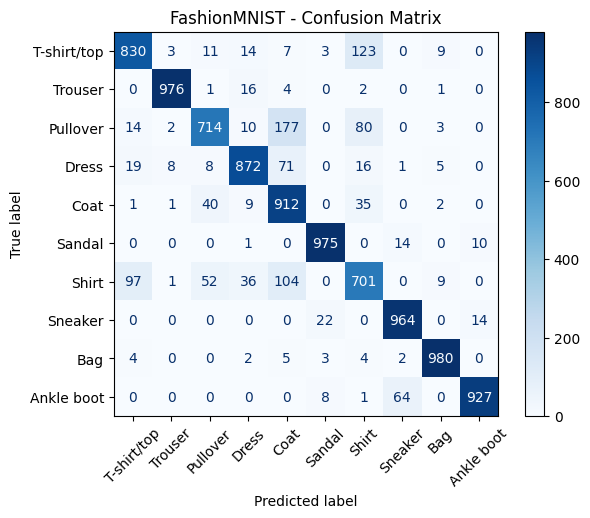

In [14]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=test_dataset.classes)

plt.figure(figsize=(17, 12))
disp.plot(cmap="Blues", values_format="d")
plt.title("FashionMNIST - Confusion Matrix")
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

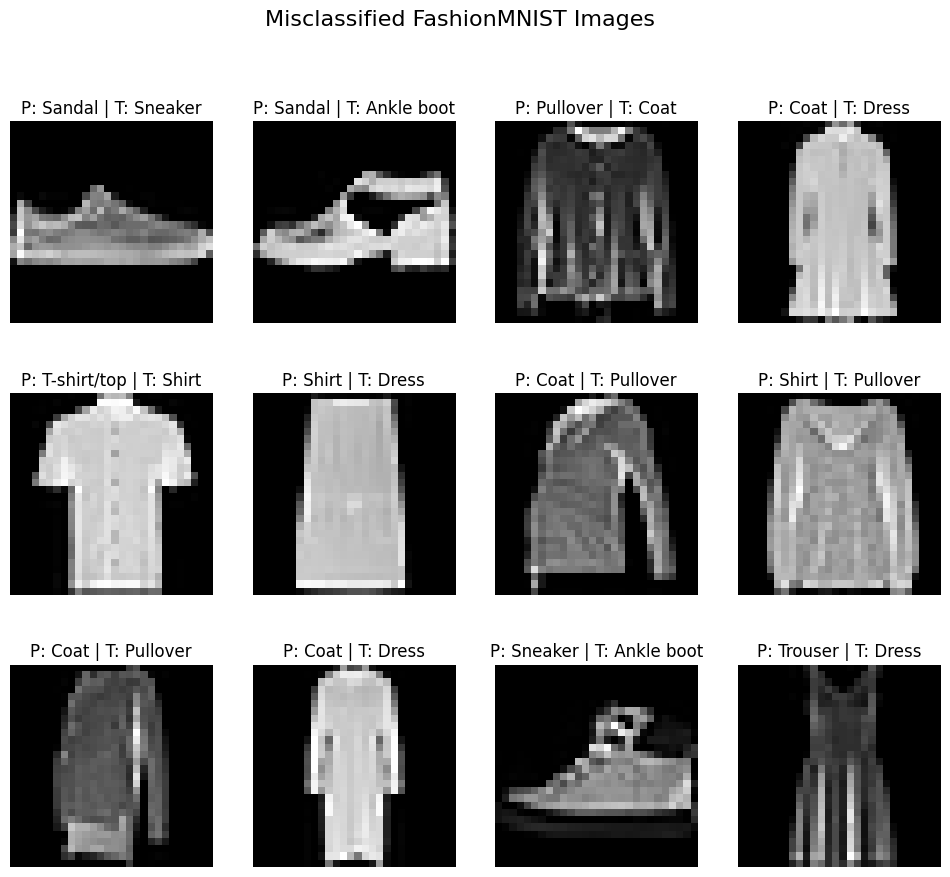

In [15]:
num_to_show = 12
plt.figure(figsize=(12, 10))
classes = test_dataset.classes

for i in range(num_to_show):
    plt.subplot(3, 4, i+1)
    plt.imshow(misclassified_images[i].squeeze(), cmap='gray')
    plt.title(f"P: {classes[misclassified_preds[i]]} | T: {classes[misclassified_labels[i]]}")
    plt.axis("off")

plt.suptitle("Misclassified FashionMNIST Images", fontsize=16)
plt.show()